# Intro to RDKit

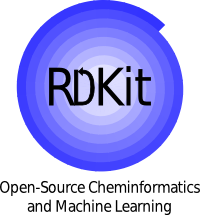

**Good place to start**
- [RDKit docs](https://www.rdkit.org/docs/index.html) <br>
&emsp;&emsp;• Basic operations, gives a good sense of general functionality <br>
- Python help strings (e.g.; help(function))<br>
    
**Links for more detailed questions/specific solutions** <br>
- http://rdkit.blogspot.com/ and/or https://greglandrum.github.io/rdkit-blog/ (RDKit blog) <br>
- [Mailing list](https://sourceforge.net/p/rdkit/mailman/rdkit-discuss/) -- generally top result in Google for RDKit issues) <br>
- [RDKit Cookbook](http://www.rdkit.org/docs/Cookbook.html)
  

**Goals for this tutorial** <br>
• How to import/manipulate molecules <br>
• Calculate TFD and RMSD <br>

## Installation and Key Packages to Import

**Use conda** <br>
```
conda install -c conda-forge rdkit
```
*Note: helpful to create specific environments to keep things organized*
```
conda create -c rdkit -n my_env_name rdkit
```

In [ ]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import xlrd
import subprocess
import fnmatch

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False   #change if you want atom numbering
size = (150, 150)                         # Smaller figures than the default
from rdkit.Chem.Draw.MolDrawing import Font
from PIL import Image


## Importing molecules

**File types**
- mol files 
```python
Chem.MolFromMolFile('file.mol')
```
- sdf files *Note: need to make sure that mol is not None type after import*
```python
Chem.ForwardSDMolSupplier('input.sdf',removeHs = False)
```
- SMILES and SMARTS
```python
Chem.MolFromSmiles('Cc1ccccc1') or Chem.MolFromSmarts('[#6][X4P](=[OX1])')
```

### Simple example (phosphines)

![phosphines](example_opr3.png "example phosphine oxides")

In [ ]:
smi = ['CC(C)c1cccc(P(=O)(c2cccc(C(C)C)c2)c2cccc(C(C)C)c2)c1', 
       'Cc1cc(F)cc(P(=O)(c2cc(C)cc(F)c2)c2cc(C)cc(F)c2)c1', 
       'CN(C)c1ccccc1-c1ccccc1P(=O)(C1CCCCC1)C1CCCCC1']

mols_smi = [Chem.MolFromSmiles(s) for s in smi]
names = ['3iPrPh3P','3F5MePh3','DavePhos']

#Use MolsToGridImage or MolToImage to visualize 2D structure
#Possible to align if common substructure
Draw.MolsToGridImage(mols_smi,legends=names)

In [ ]:
#Previously generated 3D coordinates
#Possible to embed molecules in 3D + perform conf search
inp_mollist = []
for file in os.listdir('.'):
    if fnmatch.fnmatch(file,'*.mol'):
        inp_mollist.append(file)

mollist = [Chem.MolFromMolFile(i, removeHs=False) for i in inp_mollist]

Draw.MolsToGridImage(mollist,legends=[m.GetProp("_Name") for m in mollist])

# Generate 3D coordinates

**Possible to use a variety of methods, Extended Torsion Knowledge Distance Geometry method shown here**<br>
*For details about the method see work by [Riniker and Landrum](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654)*

In [ ]:
#Crude 3D coordinates -- use MacroModel (or other similar tool) for full conformational sampling
#Experimental torsion knowledge distance geometry (ETKDG) method
params = AllChem.ETKDGv2()

mol = Chem.AddHs(mols_smi[0])
AllChem.EmbedMultipleConfs(mol, numConfs = 3, params = params)

print(Chem.MolToMolBlock(mol))

Draw.MolsToGridImage([mol])

**Possible to introduce constraints while still using ETKDG** <br>
[Blog post](https://greglandrum.github.io/rdkit-blog/conformers/exploration/2021/02/22/etkdg-and-distance-constraints.html)<br>
Following code from blog post

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolTransforms
IPythonConsole.ipython_3d = True
from rdkit.Chem import Draw
import rdkit
print(rdkit.__version__)
%pylab inline

m = Chem.AddHs(Chem.MolFromSmiles('OCCCCCCCN'))
from rdkit.Chem import rdDepictor

m2d = Chem.Mol(m)
rdDepictor.Compute2DCoords(m2d)
IPythonConsole.drawOptions.addAtomIndices = True
m2d


In [ ]:
#Constrain hydrogen bonding interaction
bounds = rdDistGeom.GetMoleculeBoundsMatrix(m)
bounds[8,0], bounds[0,8]

What happens with no constraints? Do we get realistic conformations?

In [ ]:
from rdkit import DistanceGeometry
DistanceGeometry.DoTriangleSmoothing(bounds)

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
cids = rdDistGeom.EmbedMultipleConfs(m,500,ps)
dists_etkdg = [rdMolTransforms.GetBondLength(conf,0,8) for conf in m.GetConformers()]
hist(dists_etkdg,bins=20);
title('ETKDG');
xlabel('O--N distance');

In [ ]:
print(rdMolTransforms.GetBondLength(m.GetConformer(cids[0]),0,8) )
IPythonConsole.drawMol3D(m,confId=cids[1])

In [ ]:
#Set bounds that mimic hydrogen bonding
bounds = rdDistGeom.GetMoleculeBoundsMatrix(m)
bounds[0,25] = 1.9
bounds[25,0] = 1.8
bounds[0,8] = 3.2
bounds[8,0] = 2.9
from rdkit import DistanceGeometry
DistanceGeometry.DoTriangleSmoothing(bounds)

In [ ]:
#Compare constrained structures to unconstrained structures
figsize(6,3)
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.SetBoundsMat(bounds)
cids = rdDistGeom.EmbedMultipleConfs(m,500,ps)
dists = [rdMolTransforms.GetBondLength(conf,0,8) for conf in m.GetConformers()]
hist(dists,bins=20,label='constraints');
title('ETKDG');

hist(dists_etkdg,bins=20,label='no constraints');
legend();
xlabel('O--N distance');

In [ ]:
print(rdMolTransforms.GetBondLength(m.GetConformer(cids[0]),0,25) )
IPythonConsole.drawMol3D(m,confId=cids[0])

**How has RDKit been most helpful for me?**
- matching substructures (filtering compounds, get atom indices)
- RMSD and TFD calculations
- "Chemical Reactions"

# Substructure Matching

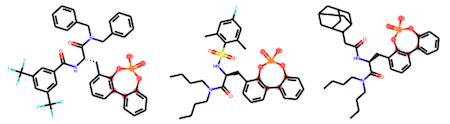

## Remove or classify compounds that match a certain functional group

**Two key functions**
- HasSubstructMatch (returns Boolean value)
- GetSubstructMatch (returns atom indices, 0-indexed)

In [ ]:
def remove_OH_SH_ald(fg_mols): #Keeps carboxylic acids
    OH = Chem.MolFromSmarts('[OX2H&!$(OC=O)]')
    SH = Chem.MolFromSmarts('[SX2H]')
    RCHO = Chem.MolFromSmarts('[CX3H1](=O)[#6]')
    fg_mols2 = []
    fg_mols3 = []
    fg_mols4 = []
    remove_mols = []

    for m in fg_mols:
        if m.HasSubstructMatch(OH):
            remove_mols.append(m)
        else:
            fg_mols2.append(m)
    
    for m in fg_mols2:
        if m.HasSubstructMatch(SH):
            remove_mols.append(m)
        else:
            fg_mols3.append(m)

    for m in fg_mols3:
        if m.HasSubstructMatch(RCHO):
            remove_mols.append(m)
        else:
            fg_mols4.append(m)

    return fg_mols4

In [ ]:
#Import test molecules
test_smi = ['OC(C1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=O','SC(CCC(O)=O)C','C1(CNCC2=CC=CC=C2)=CC=CC=C1','OCCNC']
test_mol = [Chem.MolFromSmiles(s) for s in test_smi]

Draw.MolsToGridImage(test_mol,molsPerRow=4)

In [ ]:
filtered_mol = remove_OH_SH_ald(test_mol)

Draw.MolsToGridImage(filtered_mol)

## Get Atom Numbers

In [ ]:
def mol_with_atom_index(mol): #Function used for plotting mol with atom index
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol


mol_with_atom_index(mols_smi[0])


**How do we extract these atom indices in a usable form?**
```python
m.GetSubstructMatch(sub_struct_mol)
```

In [ ]:
def get_atoms_sub(mol,sub_mol):
    atom_list = mol.GetSubstructMatch(sub_mol)
    return atom_list

opr3 = Chem.MolFromSmarts('[#6][X4P](=[OX1])')
atoms = mols_smi[0].GetSubstructMatch(opr3)

print(f"The atom indices corresponding to the phosphine oxide functionality (C-P=O) are: {atoms}")

opr3_idx = [mols_smi[0].GetAtomWithIdx(atoms[k]) for k in range(len(atoms))]

#Use neighbors to confirm each atom's identity
for j in range(len(opr3_idx)):
    neighbors = opr3_idx[j].GetNeighbors() #list of atom types
    print([x.GetAtomicNum() for x in neighbors])


# Editable Molecules

**When to use editable molecules**
- Need to make manipulations to the core structure
    - Editable Mol
    - RWMol

*Important to make sure molecules are 'sanitized'*

In [ ]:
def delete_oxygen(mol): 
    #Assume atom indexing is consistent
    opr3 = Chem.MolFromSmarts('[#6][X4P](=[OX1])')
    atom_list = mol.GetSubstructMatch(opr3)
    atoms_delete = [atom_list[-1]]
    print(atoms_delete)
    atoms_delete.sort(reverse=True)
    e_mol = Chem.EditableMol(mol)
    for atom in atoms_delete:
        e_mol.RemoveAtom(atom)
    mol_out = e_mol.GetMol()
    return mol_out

smi_inp = ['COc1c(C)cc(cc1C)P(=O)(c2cc(C)c(OC)c(C)c2)c3cc(C)c(OC)c(C)c3',
           'FC(F)(F)c(c1)cc(C(F)(F)F)cc1P(=O)(c(cc2C(F)(F)F)cc(c2)C(F)(F)F)c3cc(C(F)(F)F)cc(c3)C(F)(F)F']
mols_inp = [Chem.MolFromSmiles(x) for x in smi_inp]

Draw.MolsToGridImage(mols_inp)

In [ ]:
Draw.MolsToGridImage([delete_oxygen(m) for m in mols_inp])

# RMSD and TFD

## Definitions

### RMSD

**Root mean square deviation**<br>
Measure of average distance between atoms (important to overlay structures and account for symmetry)<br>
Can be inaccurate for larger molecules where small deviations in torsion lead to poor overlap (large spatial deviation)


### TFD

Refer to [first report](https://pubs.acs.org/doi/10.1021/ci2002318)<br>
Complementary descriptor to RMSD - normalized value (0 = identical, 1 = most dissimilar) that highlights differences in torsion


### Helpful references

Ehrman, J.; Lim, V. T.; Bannan, C. C.; Thi, N.; Kyu, D.; Mobley, D. Improving Small Molecule Force Fields By Identifying and Characterizing Small Molecules with Inconsistent Parameters. ChemRxiv 2020, Preprint, https://doi.org/10.26434/chemrxiv.12846602.v1 <br>

Lim, V. T.; Hahn, D. F.; Tresadern, G.; Bayly, C. I.; Mobley, D. Benchmark Assessment of Molecular Geometries and Energies from Small Molecule Force Fields. ChemRxiv  2020, Preprint, https://doi.org/10.26434/chemrxiv.12551867.v2<br>

Schulz-Gasch, T.; Schärfer, C.; Guba, W.; Rarey, M. TFD: Torsion Fingerprints As a New Measure To Compare Small Molecule Conformations. J. Chem. Inf. Model. 2012, 52, 1499.<br>

Friedrich, N.-O.; de Bruyn Kops, C.; Flachsenberg, F.; Sommer, K.; Rarey, M.; Kirchmair, J. J. Chem. Inf. Model. 2017, 57, 2719.

In [ ]:
#Import XPhos conformations
csd_mol_suppl = Chem.SDMolSupplier('XPhos_csd.sdf',removeHs=True)
refmol_list = [i for i in csd_mol_suppl if i is not None]

opr3_mol_suppl = Chem.SDMolSupplier('XPhos_opr3.sdf',removeHs=True)
opr3_mol = [i for i in opr3_mol_suppl if i is not None]
probemol_list = [delete_oxygen(m) for m in opr3_mol]

probemol_list[0]

In [ ]:
#Calculate RMSD - also great implementation of RDKit's RMSD calculation within MayaChemTools
from rdkit.Chem import rdMolAlign

csv0 = pd.DataFrame(columns=['RefMolID','ProbeMolID','RMSD'])

for ref, probe in [(ref,probe) for ref in refmol_list for probe in probemol_list]:
    rmsd = rdMolAlign.GetBestRMS(probe,ref)
    rmsd_series = pd.Series([ref.GetProp("_Name"),probe.GetProp("_Name"),rmsd], index=csv0.columns)
    csv0 = csv0.append(rmsd_series, ignore_index = True)

csv0

In [ ]:
#Calculate TFD
from rdkit.Chem import TorsionFingerprints

csv1 = pd.DataFrame(columns=['RefMolID','ProbeMolID','TFD'])

for ref, probe in [(ref,probe) for ref in refmol_list for probe in probemol_list]:
    try:
        tfd = Chem.TorsionFingerprints.GetTFDBetweenMolecules(ref,probe)
        tfd_series = pd.Series([ref.GetProp("_Name"),probe.GetProp("_Name"),tfd])
    except:
        tfd_series = pd.Series([ref.GetProp("_Name"),probe.GetProp("_Name"),"ERROR"])
    csv1 = csv1.append(tfd_series, ignore_index = True)
csv1.columns = ['drop1','drop2','drop3','RefMolID','ProbeMolID','TFD']
csv1 = csv1.drop(['drop1','drop2','drop3'], axis=1)

csv1

### Overlay of XPhos (ASUYAP) and XPhos (OPR3)
**RMSD = 2.09 Å and TFD = 0.08**
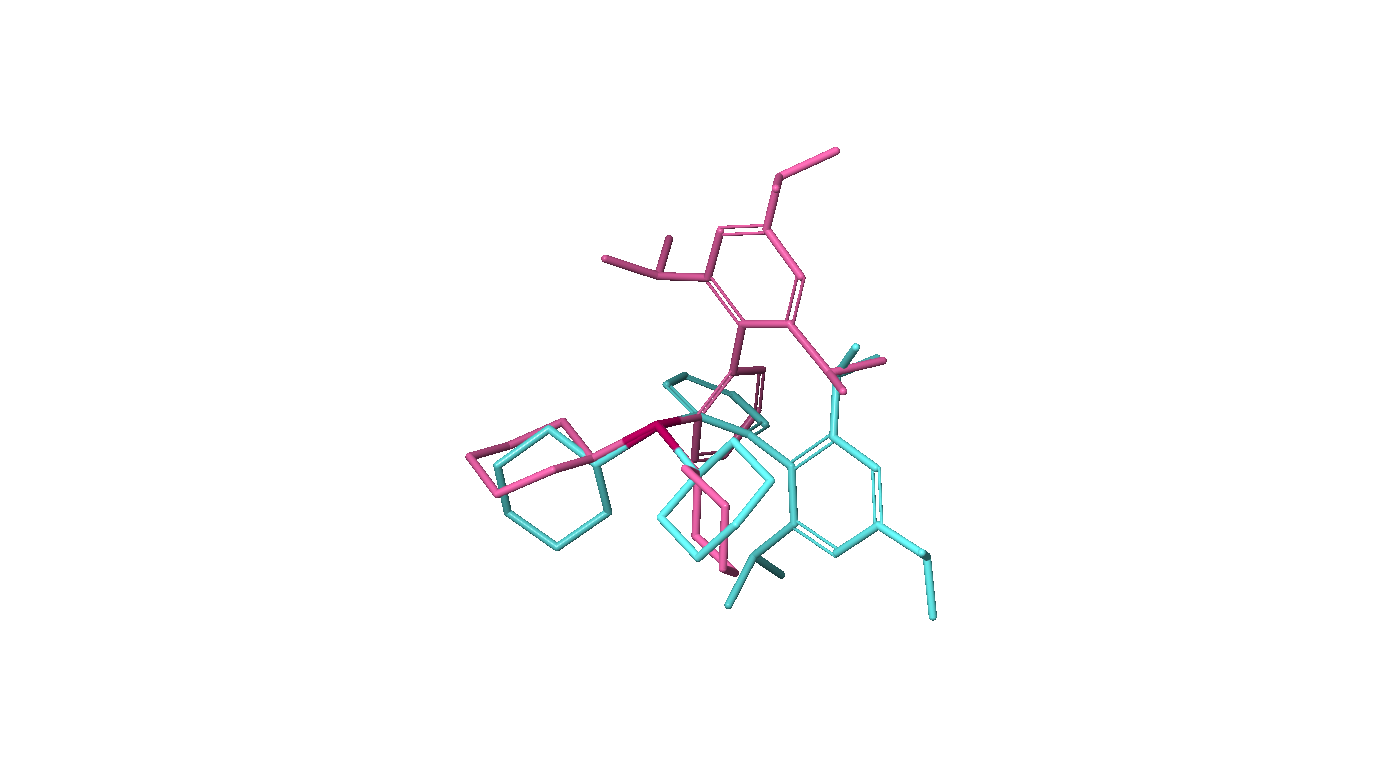

# Chemical "Reactions"

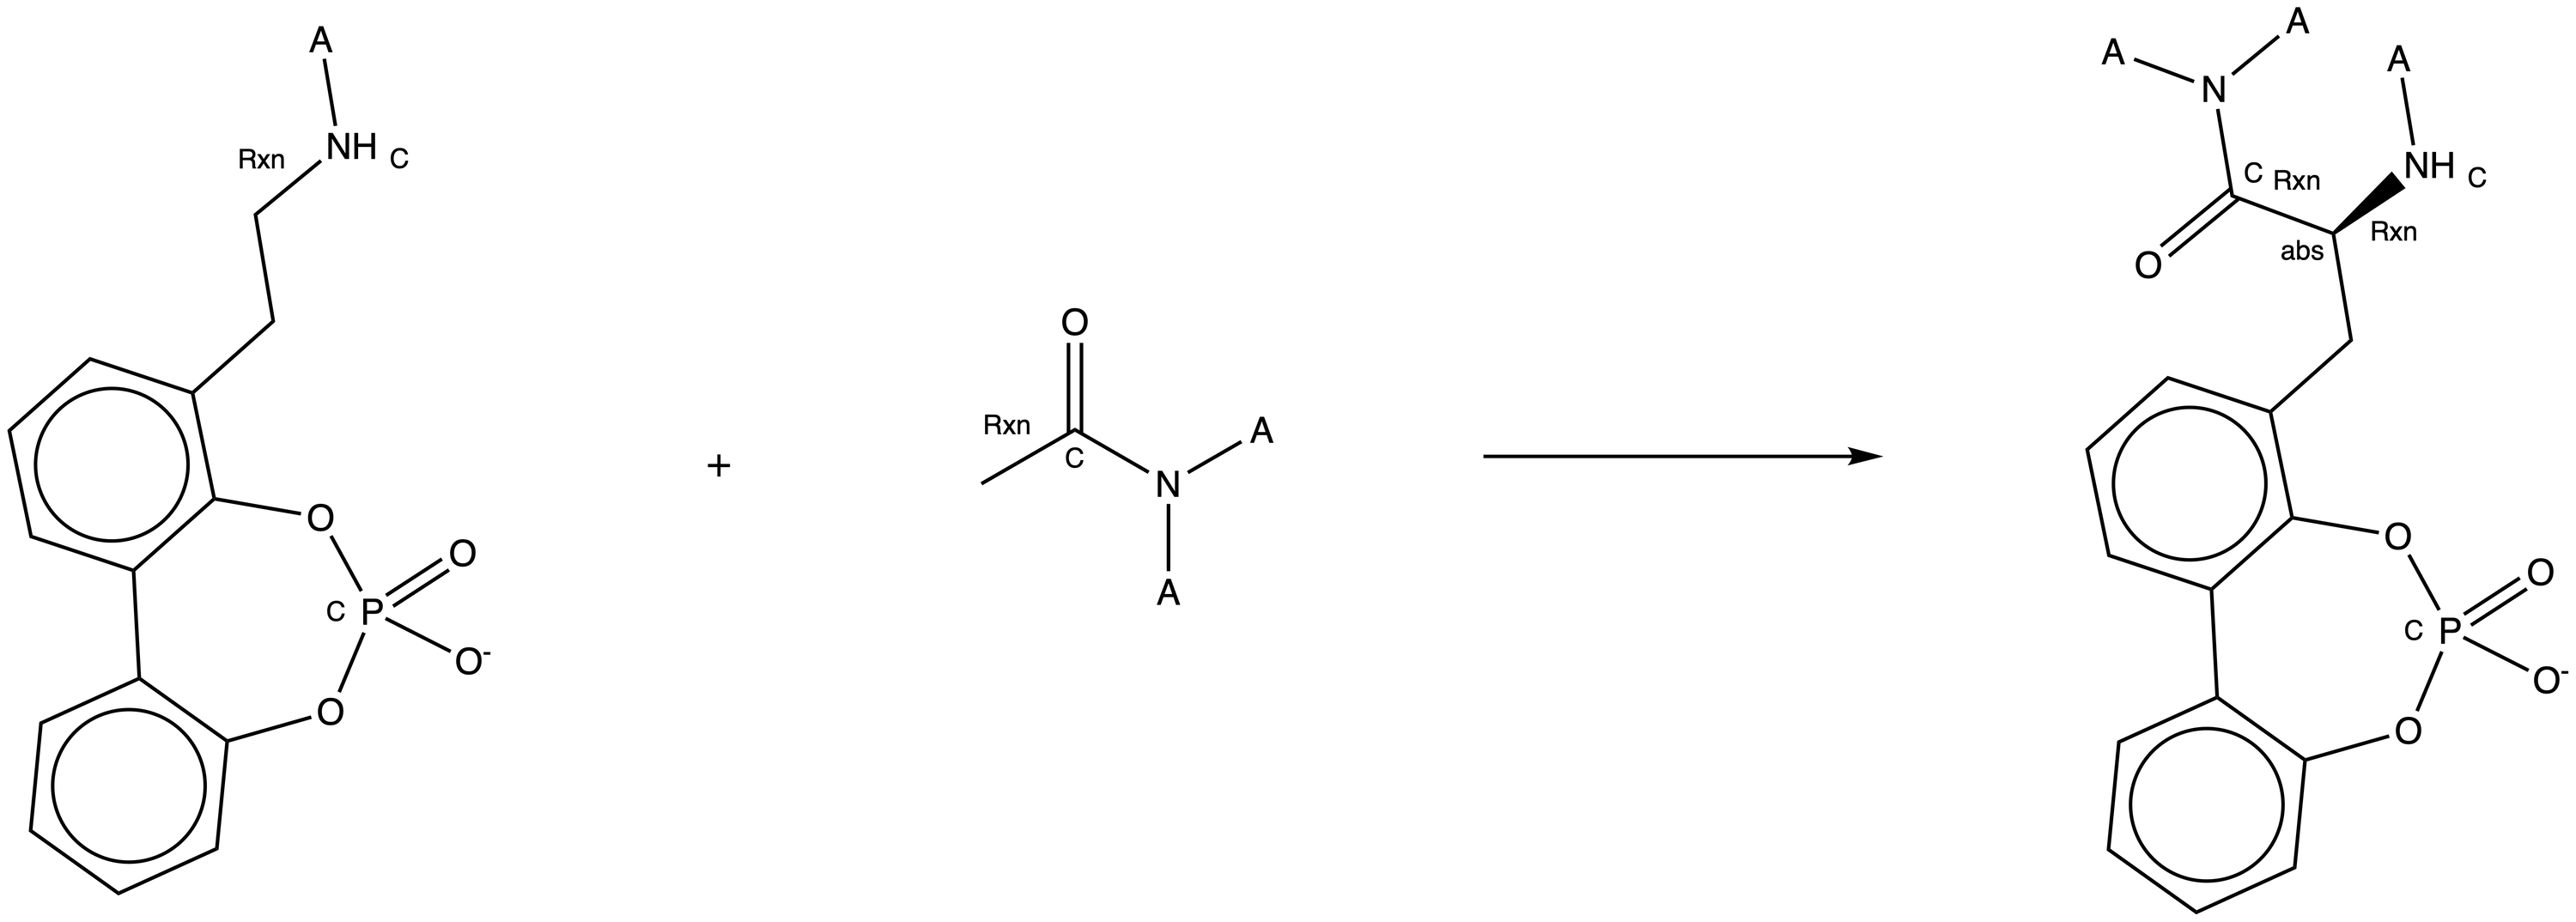

## Reaction SMARTS

In [ ]:
#Show fragment reaction (from reaction SMARTS)
#RDKit not very good at understanding chemical reactivity....only matching patterns
#Sometimes need to "protect" functional groups e.g. secondary amides see 
#https://www.rdkit.org/docs/GettingStartedInPython.html#protecting-atoms

amine_smi = ['c2ccc(CNCc1ccccc1)cc2','C1CCNCC1','CNC']
symm_amine = [Chem.MolFromSmiles(smi) for smi in amine_smi]
Draw.MolsToGridImage(symm_amine)


In [ ]:
#Convert secondary amine to amide fragment
rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])-[OD1].[N!H0:3]>>[C:1](=[O:2])[N:3]')
AcO = Chem.MolFromSmarts('CC(=O)O')
symm_amide_tuple = []

for i in range(0,len(symm_amine)):
    symm_amine[i].UpdatePropertyCache()
    product = rxn.RunReactants((AcO,symm_amine[i]))
    if len(product) == 1:
        symm_amide_tuple.append(product)
    else:
        print("")
        
amides_mols1 = [x[0] for x in symm_amide_tuple]
amides_mols2 = [x[0] for x in amides_mols1]

Draw.MolsToGridImage(amides_mols2,legends=[str(i) for i in list(range(1,4))])

## Reaction files (.rxn)

**Easiest to construct in ChemDraw**

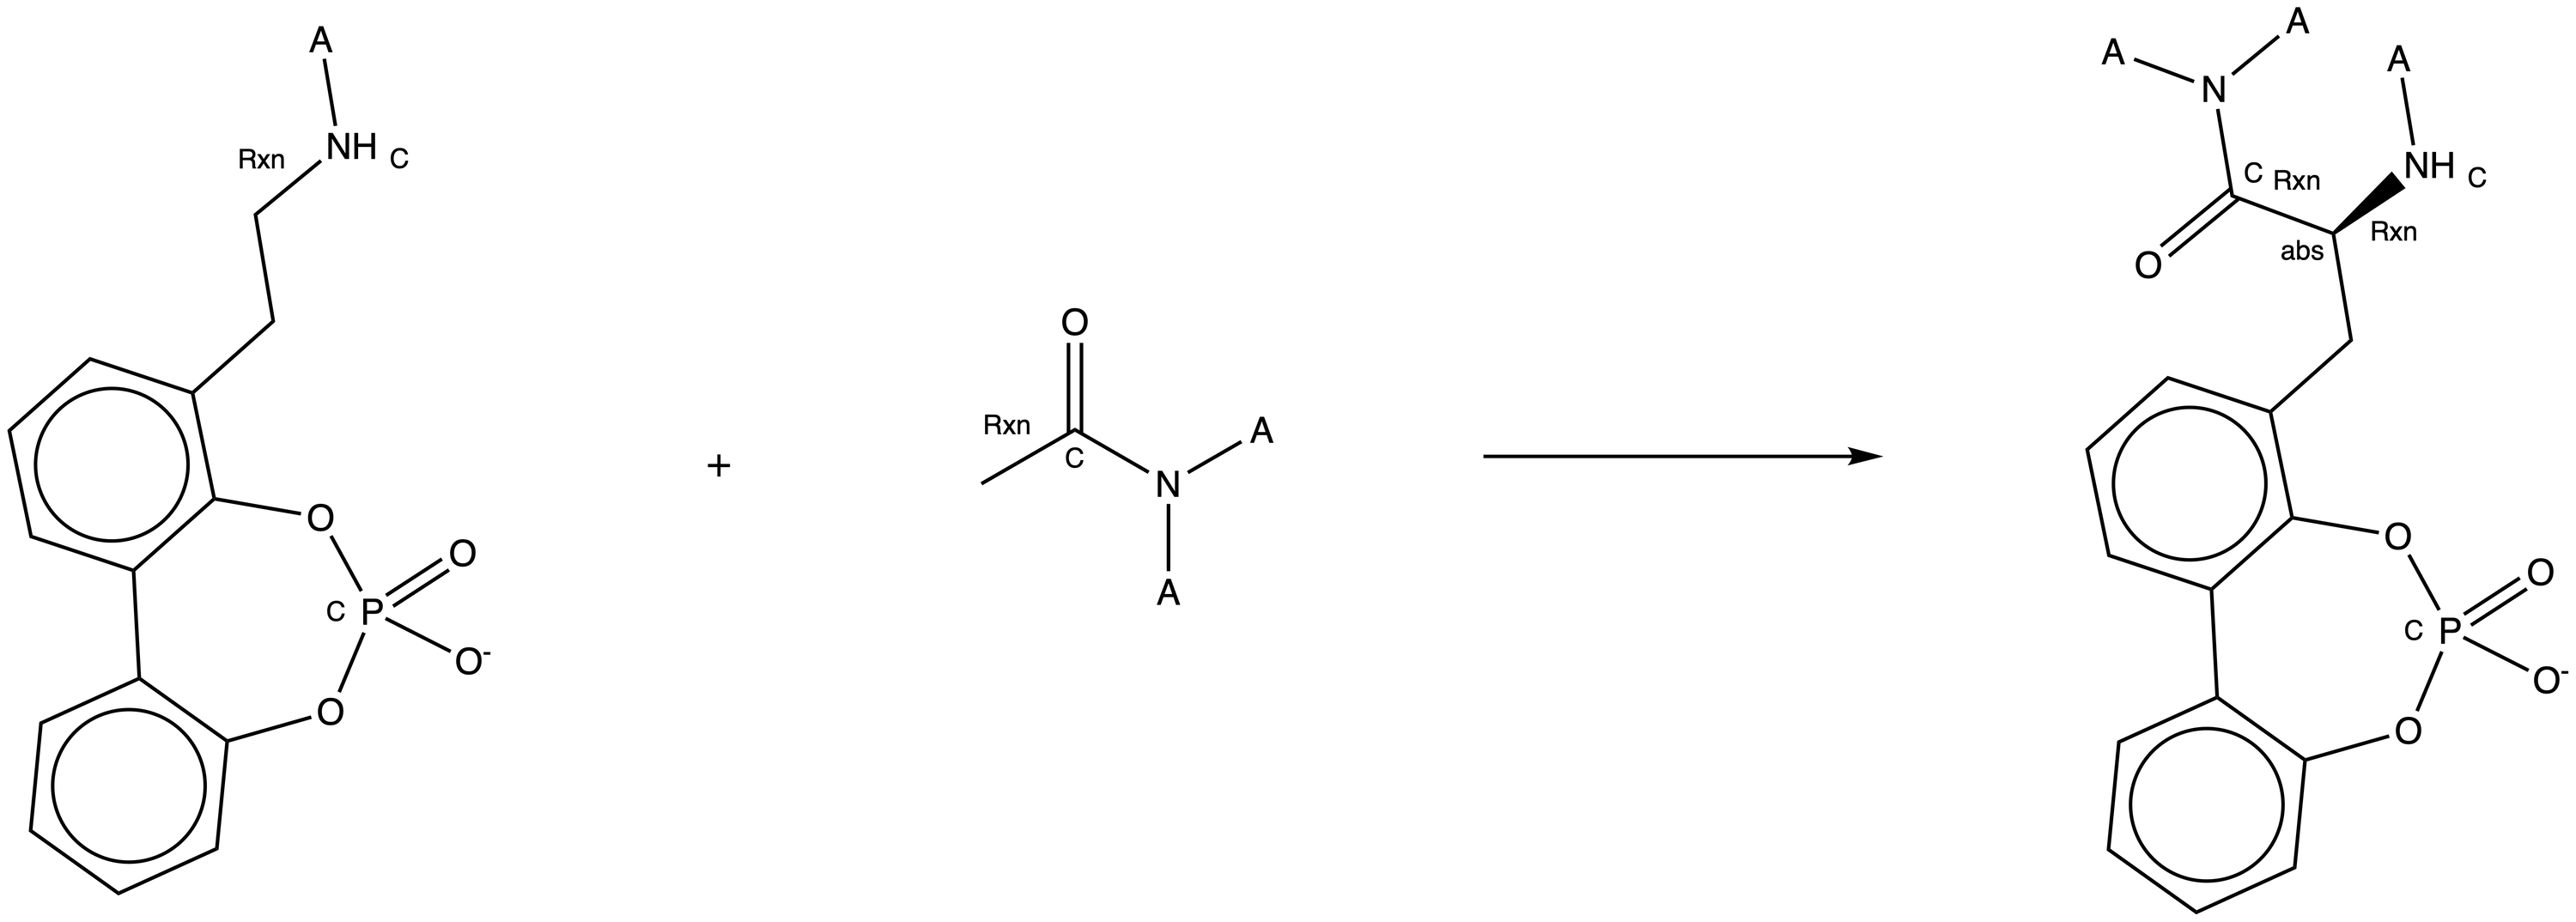

1. Draw desired reaction (modify atom types accordingly)
2. Right click to specify atom types/key features


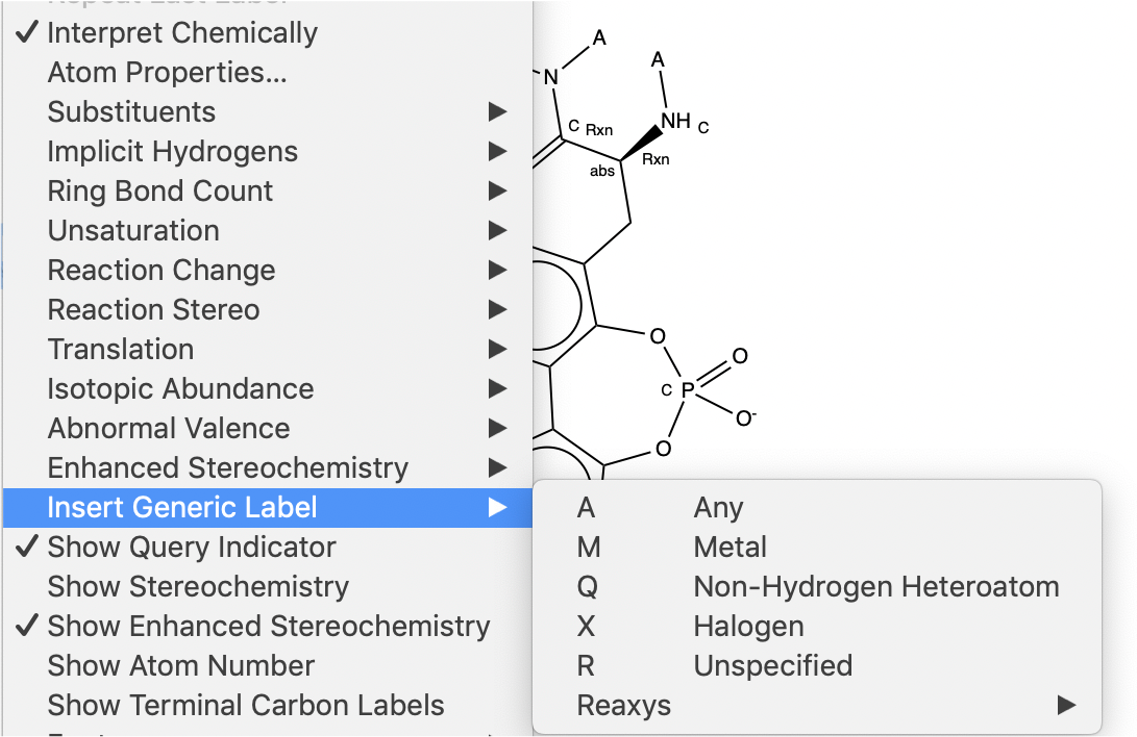

## Deconstruction of hybrid catalyst

In [ ]:
full_cats_smi = ['CCCCN(CCCC)C(=O)[C@H](Cc1cccc2c1OP(=O)([O-])Oc1ccccc1-2)NS(=O)(=O)c1c(C)cc(F)cc1C',
                 'CCCCCCCCCN(CCCCCCCCC)C(=O)[C@H](Cc1cccc2c1OP(=O)([O-])Oc1ccccc1-2)NC(=O)c1nc(C)sc1-c1cccc(F)c1',
                 'CCCCCCCCCCN(CCCCCCCCCC)C(=O)[C@H](Cc1cccc2c1OP(=O)([O-])Oc1ccccc1-2)NC(=O)CCSc1ccccc1']

Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in full_cats_smi])

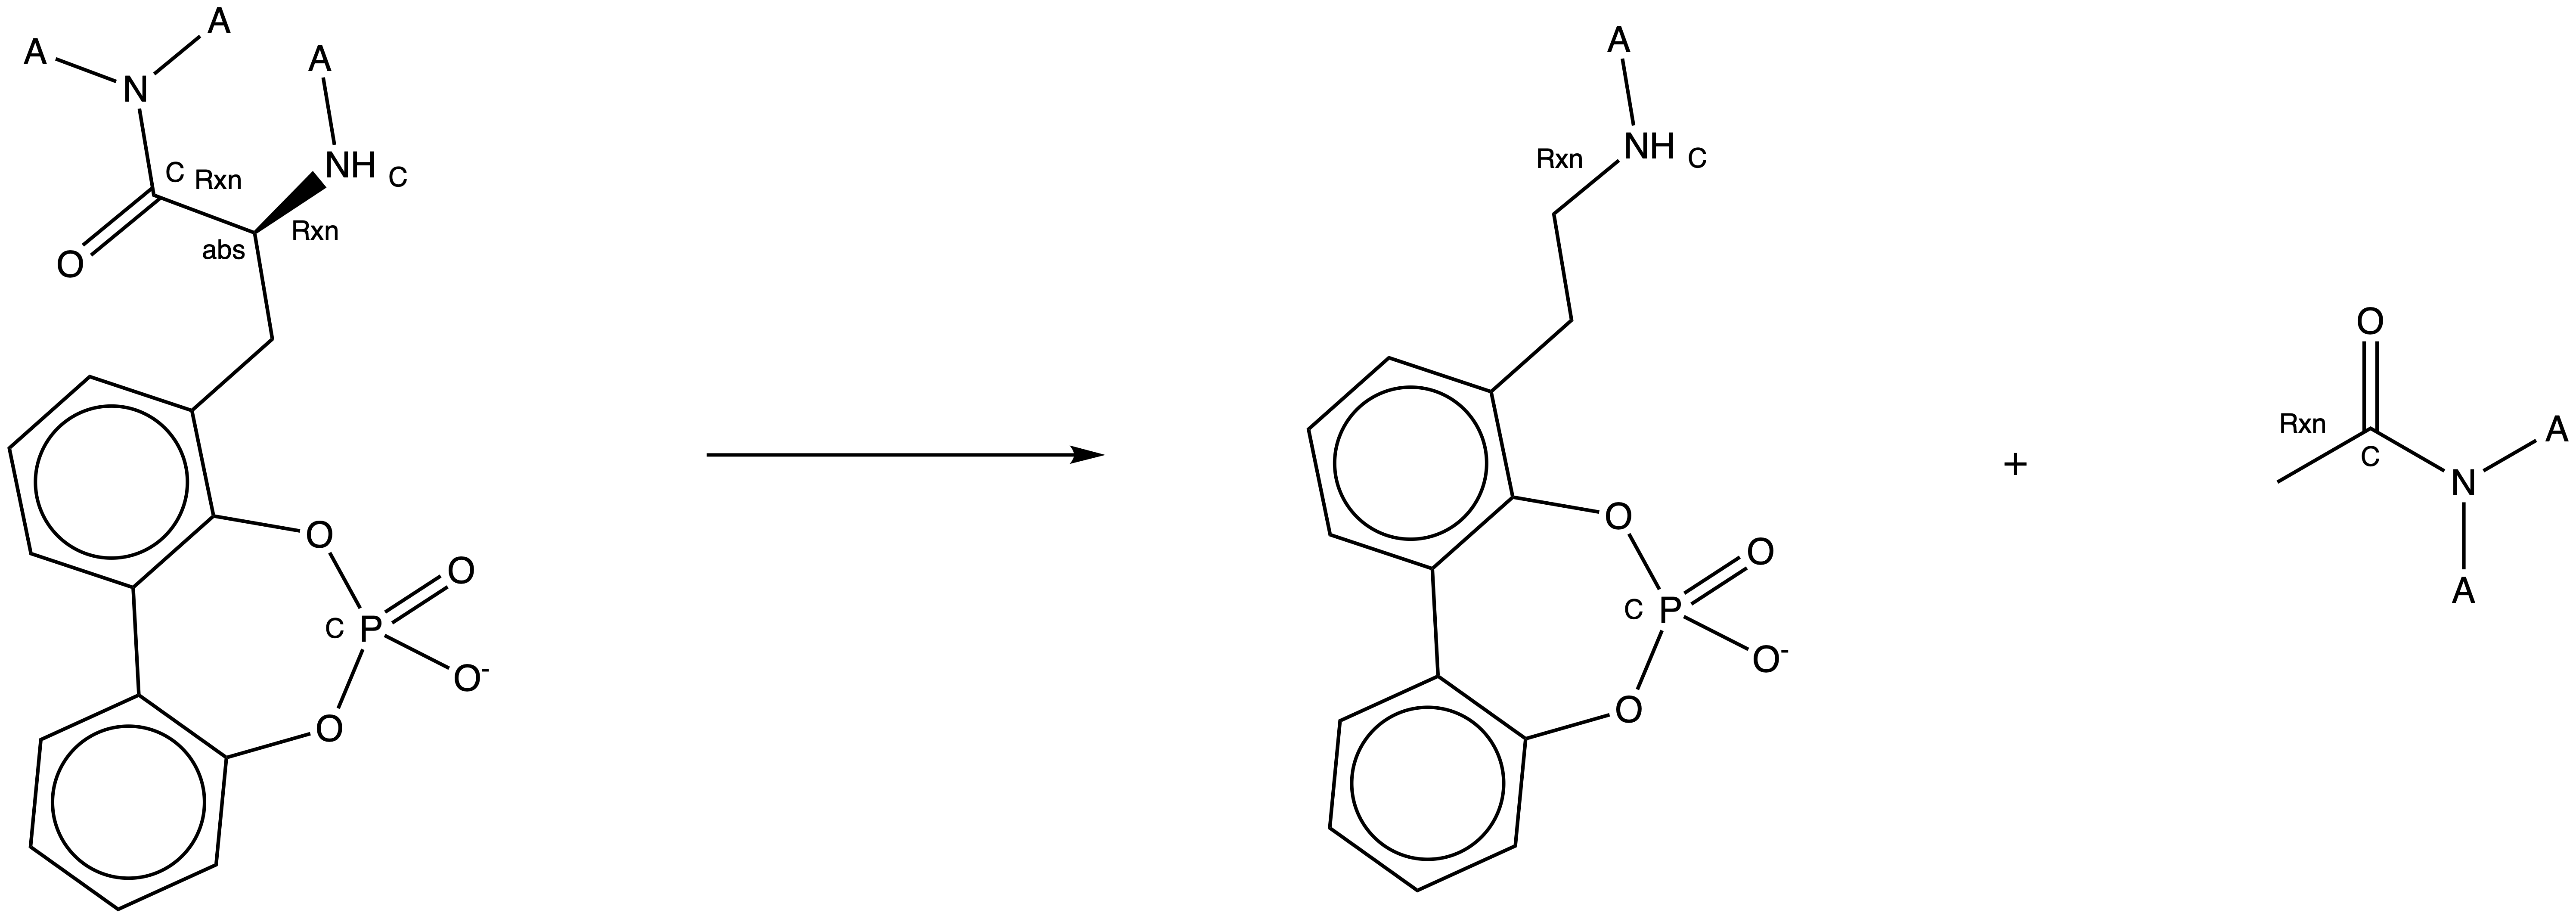

In [ ]:
decomp_1=AllChem.ReactionFromRxnFile('decomp1.rxn')
decomp_1_p=[decomp_1.RunReactants([Chem.MolFromSmiles(full_cats_smi[i])]) for i in range(len(full_cats_smi))]
amides = [decomp_1_p[i][0][1] for i in range(len(full_cats_smi))]

Draw.MolsToGridImage(amides)

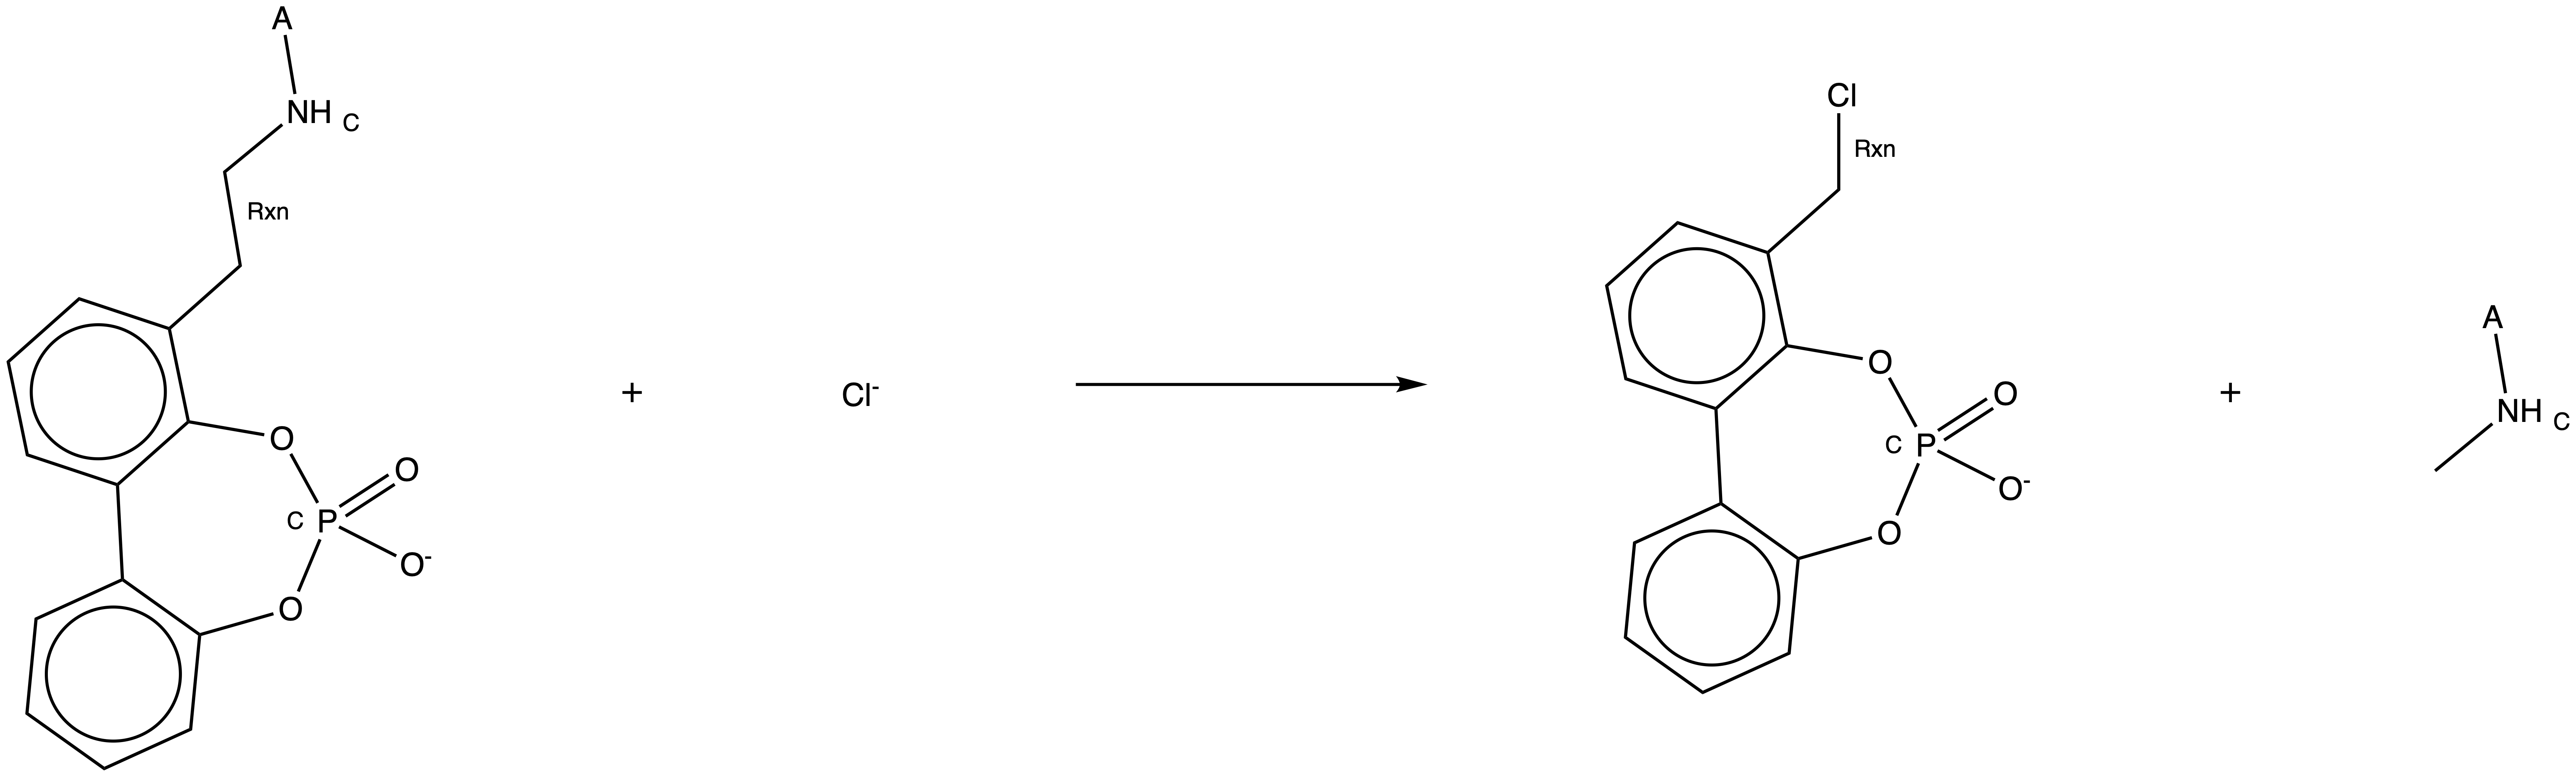

In [ ]:
for_decomp_2 = [decomp_1_p[i][0][0] for i in range(len(full_cats_smi))]
decomp_2=AllChem.ReactionFromRxnFile('decomp2.rxn')
decomp_2_p=[decomp_2.RunReactants([m,Chem.MolFromSmiles('[Cl-]')]) for m in for_decomp_2]
pgs = [decomp_2_p[i][0][1] for i in range(len(for_decomp_2))]

Draw.MolsToGridImage(pgs)

In [ ]:
pa_cl = [decomp_2_p[i][0][0] for i in range(len(for_decomp_2))]

Draw.MolsToGridImage(pa_cl)

# Other functionality

**Lots of options**
- Descriptor calculation
- Similarity calculations (Tanimoto, Dice, etc.)
- Fingerprint definitions

**See [RDKit docs](http://www.rdkit.org/docs/) for more examples**
